# Analysis of temperature/buoyancy eddy flux - 2D

This notebooks explores the properties of eddy fluxes of buoyancy under different rotations.

One way to decompose the eddy fluxes of buoyancy is to rotate to a coordinate system aligned with the mean buoyancy surfaces. Partial motivation for this comes from the quasi-adiabatic behavior of instantaneous flows in stratified fluids. However, do not assume that just because the instantaneous flow is adiabatic the eddy fluxes would be only along mean buoyancy surfaces. 

A second way to decompose the eddy fluxes is by 
(i) assuming that the eddy fluxes can be represented as a diffusive flux. 
(ii) The symmetric and anti-symmetric parts of the diffusivity tensor give two parts of the flux. 



## Rotation to mean buoyancy coordinate

The unit vector normal to a buoyancy surface is  
\begin{equation}
\mathbf{n} = \frac{\nabla \overline{b}}{|\nabla \overline{b}|}
\end{equation}

The eddy flux can then be written as (note that we consider buoyancy, but this rotation can be done for any tracer)
\begin{equation}
\mathbf{F} = \mathbf{F}_\perp + \mathbf{F}_\parallel
\end{equation}

The two components are
\begin{equation}
\mathbf{F}_\perp = (\mathbf{F}. \mathbf{n}) \mathbf{n}, \qquad \mathbf{F}_\parallel = (\mathbf{n} \times \mathbf{F}) \times \mathbf{n}
\end{equation}

The parallel component is also referred to as the skew flux. One property of this flux is that its divergence can be written in purely advective form using the indentity $\nabla . (\mathbf{A} \times \nabla \phi) = \nabla \phi. (\nabla \times \mathbf{A})$ :

\begin{equation}
\nabla.(\mathbf{F}_\parallel)  = (\nabla \times (\mathbf{n} \times F)).\mathbf{n} = \left(\nabla \times \frac{\mathbf{n} \times F}{|\nabla \overline{b}|}\right).\nabla \overline{b} = (\nabla \times \mathbf{\psi^*}). \nabla \overline{b} = \mathbf{v^*}. \nabla \overline{b}
\end{equation}


In [1]:
# load modules 
import xarray as xr
from matplotlib import pyplot as plt
from xgcm import Grid, generate_grid_ds
import numpy as np
%matplotlib inline

In [2]:
params = {
   'axes.labelsize': 12,
   'font.size': 12,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4.5, 4.5]
   }
plt.rcParams.update(params)

In [20]:
Model_Tav = xr.open_dataset('./outputs_ncfiles/Model_Tav.nc')

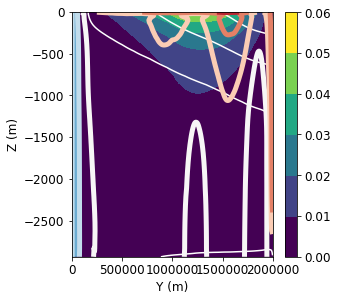

In [23]:
EKE = 0.5*(Model_Tav.VVtave - Model_Tav.vVeltave**2)
EKE.mean('XC').plot.contourf()
Model_Tav.Ttave.mean('XC').plot.contour(levels=9, colors='w')
Model_Tav.uVeltave.mean('XG').plot.contour(levels=10,cmap='RdBu_r',linewidths=5)
plt.xlabel('Y (m)')
plt.ylabel('Z (m)')

plt.savefig('2D_mean_ridge.pdf')

In [4]:
grid = Grid(Model_Tav, periodic='X')

In [5]:
#UpTp = grid.interp(Model_Tav.UTtave,'X') - grid.interp(Model_Tav.uVeltave, 'X')*Model_Tav.Ttave
VpTp = (grid.interp(Model_Tav.VTtave,'Y', boundary='extend') - grid.interp(Model_Tav.vVeltave, 'Y', boundary='extend')*Model_Tav.Ttave).mean('XC')
WpTp = (grid.interp(Model_Tav.WTtave,'Z', boundary='extend') - grid.interp(Model_Tav.wVeltave, 'Z', boundary='extend')*Model_Tav.Ttave).mean('XC')

In [6]:
T_z = (-grid.interp(grid.diff(Model_Tav.Ttave, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF).mean('XC')
T_y = (grid.interp(grid.diff(Model_Tav.Ttave, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3).mean('XC')
#T_x =  grid.interp(grid.diff(Model_Tav.Ttave, 'X'), 'X')/5e3

In [7]:
Fbmod = (VpTp**2 + WpTp**2)**0.5
gradbmod = (T_y**2 + T_z**2)**0.5

In [8]:
Fb_perp_mod = (VpTp*T_y + WpTp*T_z) / gradbmod
#Fb_perp_x = Fb_perp_mod*T_x / gradbmod
Fb_perp_y = Fb_perp_mod*T_y / gradbmod
Fb_perp_z = Fb_perp_mod*T_z / gradbmod

In [9]:
#Fb_para_x = UpTp - Fb_perp_x
Fb_para_y = VpTp - Fb_perp_y
Fb_para_z = WpTp - Fb_perp_z

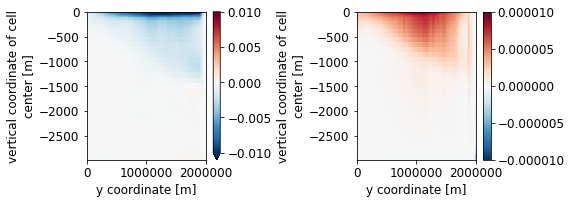

In [13]:
plt.figure(figsize=(8,3))

#plt.subplot(131)
#UpTp.sel(Z=-1000, method='nearest').plot(vmin=-1e-2)

plt.subplot(121)
VpTp.plot(vmin=-1e-2)

plt.subplot(122)
WpTp.plot(vmin=-1e-5)
plt.tight_layout()

The eddy fluxes in the horizontal directions are comparable in magnitude. While the vertical flux is small. 

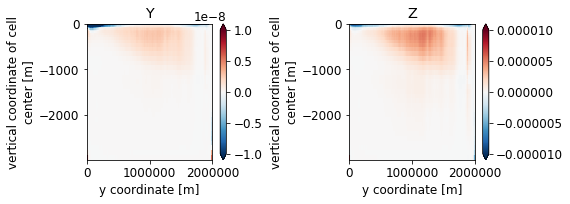

In [15]:
plt.figure(figsize=(8,3))

plt.subplot(121)
Fb_perp_y.plot(vmin=-1e-8)
plt.title('Y')

plt.subplot(122)
Fb_perp_z.plot(vmin=-1e-5)
plt.title('Z')
plt.tight_layout()

The eddy flux perpendicular to the b gradient has the largest component in the vertical, and smaller ones in the horizontal. This is to be expected since the buoyancy surfaces are close to being flat. 

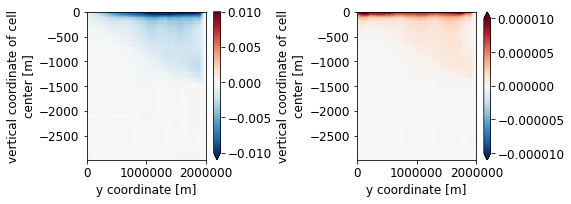

In [16]:
plt.figure(figsize=(8,3))

plt.subplot(121)
Fb_para_y.plot(vmin=-1e-2)

plt.subplot(122)
Fb_para_z.plot(vmin=-1e-5)
plt.tight_layout()

The buoyancy flux parallel to the mean contours looks quite similar to the horizontal fluxes. 

The vertical component of this flux adds with the vertical component of the perp component to give the vertical flux in cartesian coordinates. 

In [17]:
# divergences of these fluxes 
divF = grid.interp(grid.diff(VpTp, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3 + \
       -grid.interp(grid.diff(WpTp, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
    
divFperp = grid.interp(grid.diff(Fb_perp_y, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3 + \
       -grid.interp(grid.diff(Fb_perp_z, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF
        
divFpara = grid.interp(grid.diff(Fb_para_y, 'Y', boundary='extend'), 'Y', boundary='extend')/5e3 + \
       -grid.interp(grid.diff(Fb_para_z, 'Z', boundary='extend'), 'Z', boundary='extend')/Model_Tav.drF

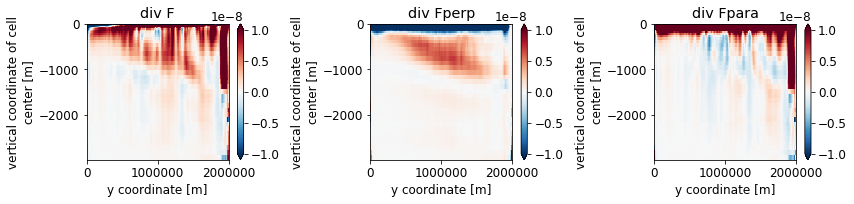

In [19]:
plt.figure(figsize=(12,3))
plt.subplot(131)
divF.plot(vmin=-1e-8)
plt.title('div F')

plt.subplot(132)
divFperp.plot(vmin=-1e-8)
plt.title('div Fperp')

plt.subplot(133)
divFpara.plot(vmin=-1e-8)
plt.title('div Fpara')

plt.tight_layout()

The divergence of the full flux is mostly a result of the divergence of the flux due to the parallel component. 

The non-zero divergence of perpendicular eddy flux of buoyancy is a reult of the dissipation and variance transport. Note that F_para does not enter the buoyancy variance equation. 


Summary:
This analysis shows that the $\mathbf{F}_{perp}$ is much smaller than $\mathbf{F}_{para}$, and this is also the case for the divergence. However, while the $\mathbf{F}_{perp}$ is orders of magnitude smaller than $\mathbf{F}_{para}$, the $\nabla. \mathbf{F}_{perp}$ is only about an order of magnitude or less smaller than $\nabla.\mathbf{F}_{para}$. 

If the tracer fluxes are decomposed into flux due to quasi-stokes stream function and remaining. The divergence of the remaining flux is guaranteed to be zero. This remaining flux can be compared to the perpendicular flux, which has non zero divergence. This implies that a "perfect" parameterization would parameterize the quasi-stokes stream function, and not the along surface flux. 

However, this difference is small and may be neglected, considering the large uncertainities already present in the parameters (there is no perfect theory for the parameterization). MM2001 is only a theory for telling us what to parameterize. 

### Separation of diffusivity tensor into two components

The above analysis is dependent on the tracer! For each tracer the vectors of along and across mean tracer surfaces will be very different. We would like to have a unified parameter set, which is tracer independent (we don't want a seprate parameterization) for each individual tracer. 

This is perfectly possible in GLM. However, GLM can't be applied practically. Also, it gives us the evolution equation for the lagrangian mean tracer concentration. This second concern is less of an issue, considering that the correct interpretation of GM is that it works on a modified mean (and not eulerian mean). 

An approximation can be done in Eulerian world (which formally comes from small amplitude wave approximation of GLM/or homogenization) that expresses the tracer eddy fluxes as a diffusivity tensor times the mean gradient. Many tracers can be used to diagnose the best fit tensor. Our work shows that this tensor is able to reproduce tracer fluxes even for unknown/new tracers with decent accuracy. However, being an approximation you lose some of the theoretical perfection, which will be discussed later. 

The idea is quite simple: 

\begin{equation}
\mathbf{F}_c = - \mathbf{K} \nabla C = - (\mathbf{A + S}) \nabla C
\end{equation}
for any tracer. 

The split into the antisymmetric and symmetric parts allows looks similar to the break down into along and across mean gradient. This is because the flux due to the antisymmetric part is skew to the gradient (similar to the along fluxes in previous section), and the symmetric part is what enters the variance equation. However, it is not the same thing, there are number of subtle differences, which will be discussed later. The main reason for the difference is that K is tracer independent. 

In [50]:
from funcs import *

In [51]:
Lcoarse = 50e3
diff_tensor = xr.open_dataset('./outputs_ncfiles/diff_tensor_'+str(int(Lcoarse//1e3))+'km.nc')
Trac_coarse = xr.open_dataset('./outputs_ncfiles/Trac_coarse_'+str(int(Lcoarse//1e3))+'km')
Vels_coarse = xr.open_dataset('./outputs_ncfiles/Vels_coarse_'+str(int(Lcoarse//1e3))+'km')
T_coarse    = xr.open_dataset('./outputs_ncfiles/T_coarse_'+str(int(Lcoarse//1e3))+'km')

In [52]:
list_trac = ['TRAC01', 'TRAC02', 'TRAC03', 'TRAC04', 'TRAC05', 
            'TRAC06', 'TRAC07', 'TRAC08', 'TRAC09', 'TRAC10', 
            'TRAC11', 'TRAC12', 'TRAC13', 'TRAC14', 'TRAC15', 
            'TRAC16', 'TRAC17', 'TRAC18', 'TRAC19', 'TRAC20']

In [53]:
[UpCp, VpCp, WpCp] = get_flux_arrays(Trac_coarse, list_trac)
[dCdx, dCdy, dCdz]= get_grad_arrays(Trac_coarse, list_trac)

In [54]:
fluxT = xr.Dataset({'UpCp':T_coarse.UpTp, 'VpCp':T_coarse.VpTp, 'WpCp':T_coarse.WpTp})
gradT = xr.Dataset({'dCdx':T_coarse.T_X, 'dCdy':T_coarse.T_Y, 'dCdz':T_coarse.T_Z})

In [55]:
flux = xr.Dataset({'UpCp':UpCp, 'VpCp':VpCp, 'WpCp':WpCp})
grads = xr.Dataset({'dCdx':dCdx, 'dCdy':dCdy, 'dCdz':dCdz})

In [56]:
def flux_reconstruct(tensor, flux, grads):

    recUflux = -(tensor.sel(i=0, j=0)*grads.dCdx + tensor.sel(i=0, j=1)*grads.dCdy + tensor.sel(i=0, j=2)*grads.dCdz)
    recVflux = -(tensor.sel(i=1, j=0)*grads.dCdx + tensor.sel(i=1, j=1)*grads.dCdy + tensor.sel(i=1, j=2)*grads.dCdz)
    recWflux = -(tensor.sel(i=2, j=0)*grads.dCdx + tensor.sel(i=2, j=1)*grads.dCdy + tensor.sel(i=2, j=2)*grads.dCdz)

    errU = np.abs(flux.UpCp - recUflux)/np.abs(flux.UpCp)
    errV = np.abs(flux.VpCp - recVflux)/np.abs(flux.VpCp)
    errW = np.abs(flux.WpCp - recWflux)/np.abs(flux.WpCp)
    
    flux_rec=xr.Dataset({'UpCp':recUflux, 'VpCp':recVflux, 'WpCp':recWflux,
                                'errU':errU, 'errV':errV, 'errW':errW})
    
    return flux_rec

In [57]:
frb = flux_reconstruct(diff_tensor.Kcorr, fluxT, gradT)
flux_rec_buoy_AT = flux_reconstruct(diff_tensor.AT, fluxT, gradT) 
flux_rec_buoy_ST = flux_reconstruct(diff_tensor.ST, fluxT, gradT) 

In [60]:
Xcoarse = T_coarse.XCcoarse.data
Ycoarse = T_coarse.YCcoarse.data
Z = T_coarse.Z.data

Ypcol = np.append(Ycoarse, Ycoarse[-1]+Lcoarse)-Lcoarse/2
Xpcol = np.append(Xcoarse, Xcoarse[-1]+Lcoarse)-Lcoarse/2
Zpcol = np.append(Z, Z[-1])

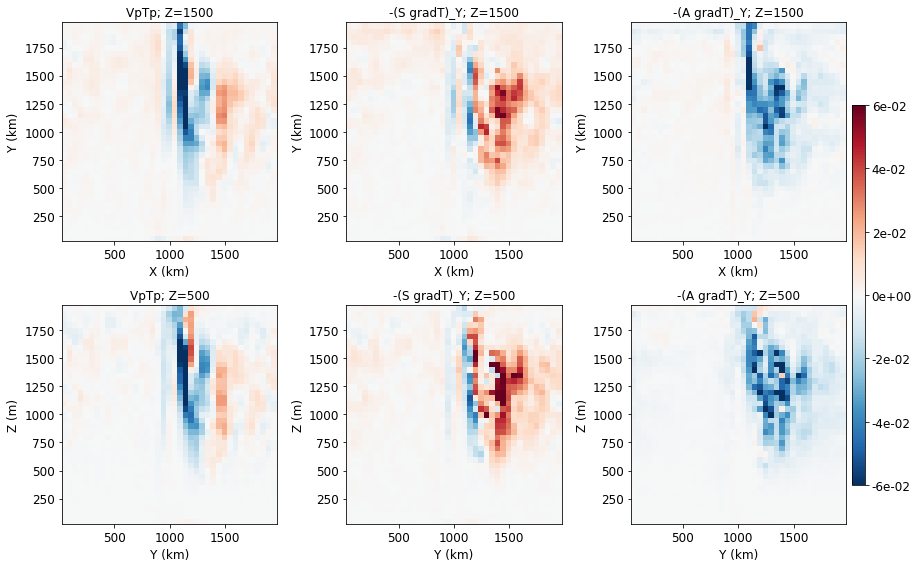

In [95]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_ST.VpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-(S gradT)_Y; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.VpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,2].set_title('-(A gradT)_Y; Z=1500')
ax[0,2].set_xlabel('X (km)')
ax[0,2].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.VpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('VpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_ST.VpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-(S gradT)_Y; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

im=ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.VpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,2].set_title('-(A gradT)_Y; Z=500')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')
cbar_ax = fig.add_axes([0.99, 0.15, 0.015, 0.66])
fig.colorbar(im, cax=cbar_ax,format='%.0e')


plt.tight_layout()

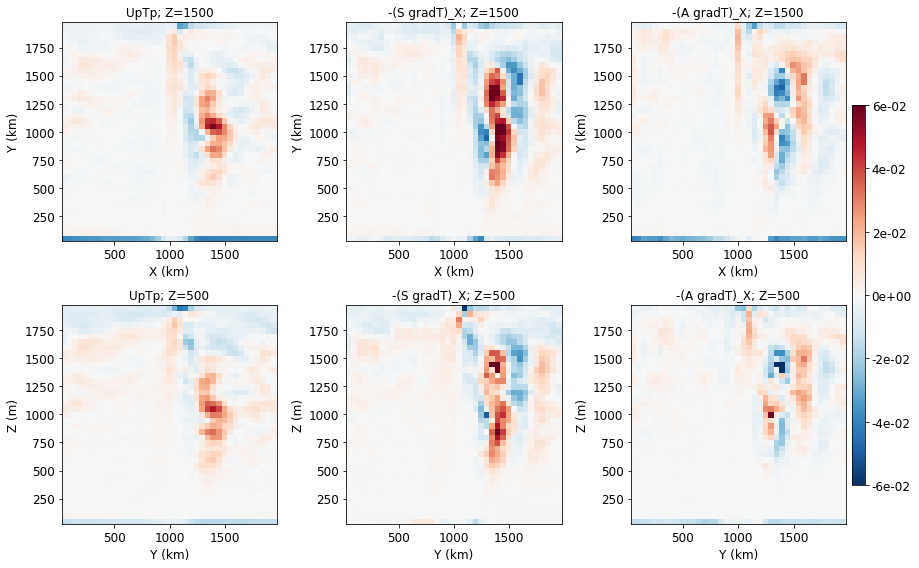

In [96]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.UpTp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,0].set_title('UpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_ST.UpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,1].set_title('-(S gradT)_X; Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.UpCp.sel(Z=-1500, method='nearest'), vmin=-0.01, vmax=0.01, cmap='RdBu_r')
ax[0,2].set_title('-(A gradT)_X; Z=1500')
ax[0,2].set_xlabel('X (km)')
ax[0,2].set_ylabel('Y (km)')

ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, T_coarse.UpTp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,0].set_title('UpTp; Z=500')
ax[1,0].set_xlabel('Y (km)')
ax[1,0].set_ylabel('Z (m)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_ST.UpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,1].set_title('-(S gradT)_X; Z=500')
ax[1,1].set_xlabel('Y (km)')
ax[1,1].set_ylabel('Z (m)')

im=ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, flux_rec_buoy_AT.UpCp.sel(Z=-500, method='nearest'), vmin=-0.06, vmax=0.06, cmap='RdBu_r')
ax[1,2].set_title('-(A gradT)_X; Z=500')
ax[1,2].set_xlabel('Y (km)')
ax[1,2].set_ylabel('Z (m)')
cbar_ax = fig.add_axes([0.99, 0.15, 0.015, 0.66])
fig.colorbar(im, cax=cbar_ax,format='%.0e')

plt.tight_layout()

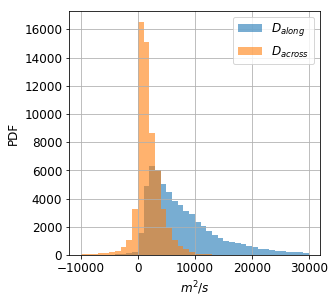

In [65]:
bins = np.linspace(-1e4,3e4,41)
[_,_,_]=diff_tensor.eigvalsST.isel(ii=2).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{along}$')
[_,_,_]=diff_tensor.eigvalsST.isel(ii=1).where(T_coarse.hFacCcoarse==1.).plot.hist(bins=bins, alpha=0.6, label='$D_{across}$')
plt.legend()
plt.title('')
plt.xlabel('$m^2/s$')
plt.ylabel('PDF')
plt.grid()
#plt.savefig('figKpdf.pdf', dpi=200,bbox_inches='tight')

In [66]:
grid_ds = xr.Dataset()
grid_ds['TRAC01'] = Trac_coarse['TRAC01'] # use for Coarse grid
grid_ds['wVeltave'] = Model_Tav['wVeltave'] # needed for Z grid 
grid_ds = grid_ds.drop(['wVeltave','XC','YC']).isel(XC=0, YC=0)

In [69]:
# calculate gradients on coarse grid 
ds = generate_grid_ds(grid_ds, {'X': 'XCcoarse', 'Y':'YCcoarse'})
grid = Grid(ds, periodic='X')

In [71]:
gSgb1 = grid.interp(grid.diff(flux_rec_buoy_ST.UpCp, 'X'), 'X')/Lcoarse  #+ \
gSgb2 = grid.interp(grid.diff(flux_rec_buoy_ST.VpCp, 'Y', boundary='extend'), 'Y', boundary='extend')/Lcoarse #+ \
gSgb3 = grid.interp(grid.diff(flux_rec_buoy_ST.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/grid_ds.drF

In [72]:
gAgb1 = grid.interp(grid.diff(flux_rec_buoy_AT.UpCp, 'X'), 'X')/Lcoarse  #+ \
gAgb2 = grid.interp(grid.diff(flux_rec_buoy_AT.VpCp, 'Y', boundary='extend'), 'Y', boundary='extend')/Lcoarse #+ \
gAgb3 = grid.interp(grid.diff(flux_rec_buoy_AT.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/grid_ds.drF

In [82]:
gKgb1 = grid.interp(grid.diff(frb.UpCp, 'X'), 'X')/Lcoarse  #+ \
gKgb2 = grid.interp(grid.diff(frb.VpCp, 'Y', boundary='extend'), 'Y', boundary='extend')/Lcoarse #+ \
gKgb3 = grid.interp(grid.diff(frb.WpCp, 'Z', boundary='extend'), 'Z', boundary='extend')/grid_ds.drF

In [84]:
gTflux1 = grid.interp(grid.diff(T_coarse.UpTp, 'X'), 'X')/Lcoarse  #+ \
gTflux2 = grid.interp(grid.diff(T_coarse.VpTp, 'Y', boundary='extend'), 'Y', boundary='extend')/Lcoarse #+ \
gTflux3 = grid.interp(grid.diff(T_coarse.WpTp, 'Z', boundary='extend'), 'Z', boundary='extend')/grid_ds.drF

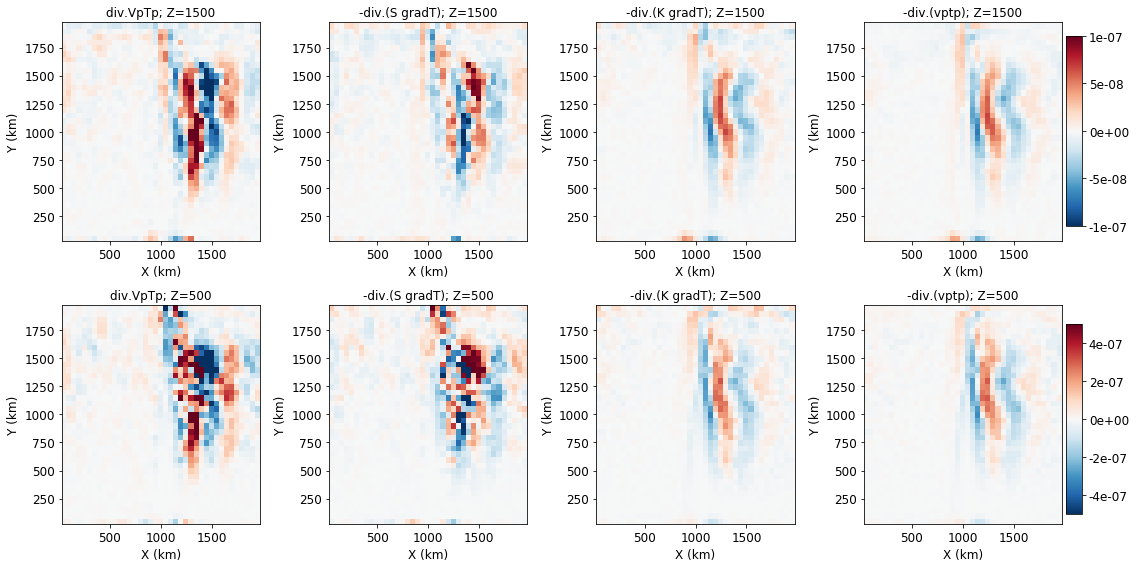

In [101]:
fig, ax = plt.subplots(2, 4, figsize=(15, 8))

ax[0,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gSgb1+gSgb2+gSgb3).sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,0].set_title('div.VpTp; Z=1500')
ax[0,0].set_xlabel('X (km)')
ax[0,0].set_ylabel('Y (km)')

ax[0,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gAgb1+gAgb2+gAgb3).sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,1].set_title('-div.(S gradT); Z=1500')
ax[0,1].set_xlabel('X (km)')
ax[0,1].set_ylabel('Y (km)')

ax[0,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gKgb1+gKgb2+gKgb3).sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,2].set_title('-div.(K gradT); Z=1500')
ax[0,2].set_xlabel('X (km)')
ax[0,2].set_ylabel('Y (km)')

im=ax[0,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gTflux1+gTflux2+gTflux3).sel(Z=-1500, method='nearest'), vmin=-1e-7, vmax=1e-7, cmap='RdBu_r')
ax[0,3].set_title('-div.(vptp); Z=1500')
ax[0,3].set_xlabel('X (km)')
ax[0,3].set_ylabel('Y (km)')
cbar_ax = fig.add_axes([0.99, 0.6, 0.015, 0.33])
fig.colorbar(im, cax=cbar_ax,format='%.0e')


ax[1,0].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gSgb1+gSgb2+gSgb3).sel(Z=-500, method='nearest'), vmin=-5e-7, vmax=5e-7, cmap='RdBu_r')
ax[1,0].set_title('div.VpTp; Z=500')
ax[1,0].set_xlabel('X (km)')
ax[1,0].set_ylabel('Y (km)')

ax[1,1].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gAgb1+gAgb2+gAgb3).sel(Z=-500, method='nearest'), vmin=-5e-7, vmax=5e-7, cmap='RdBu_r')
ax[1,1].set_title('-div.(S gradT); Z=500')
ax[1,1].set_xlabel('X (km)')
ax[1,1].set_ylabel('Y (km)')

ax[1,2].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gKgb1+gKgb2+gKgb3).sel(Z=-500, method='nearest'), vmin=-5e-7, vmax=5e-7, cmap='RdBu_r')
ax[1,2].set_title('-div.(K gradT); Z=500')
ax[1,2].set_xlabel('X (km)')
ax[1,2].set_ylabel('Y (km)')

im=ax[1,3].pcolormesh(Xcoarse/1e3, Ycoarse/1e3, (gTflux1+gTflux2+gTflux3).sel(Z=-500, method='nearest'), vmin=-5e-7, vmax=5e-7, cmap='RdBu_r')
ax[1,3].set_title('-div.(vptp); Z=500')
ax[1,3].set_xlabel('X (km)')
ax[1,3].set_ylabel('Y (km)')
cbar_ax = fig.add_axes([0.99, 0.1, 0.015, 0.33])
fig.colorbar(im, cax=cbar_ax,format='%.0e')

plt.tight_layout()

Summary: 
- Decomposition works WAY better than anyone would have guesed! (could look at error metrics too. Even for gradients)
- Both A and S are necessary when we want to reconstruct flux of any tracer (even buoyancy!!)
- The flux resulting from S, is not the same as the $F_{\perp}$.
- Thus, A is not sufficient to recontruxt T flux -> $A \neq A_{GM}$.  (It does not seem that they are the same even approximately.)

Summary:
1. In the variance equation for a single tracer the symmetric tensor provides too much information. Three tracer variance equations are needed to fully pin down the symmetric tensor. 
2. The equation for tracer variance normalized by its gradient ($\frac{b'^2}{N^2}$) can be used to derive an equation where A features. This can also be done for 3 tracers in principle to fully determine A. 